# Lab Week 11: SHAP Values and Explainability for non-linear models

In this lab we will study how to make complex model more explainable. This is just but a tiny part of what transparency and interpretability actually are, so the topics covered here must be consider a necessary, but not sufficient, step in understanding complex models.

Remember: the onus is on the modeller to prove that ML is fair and transparent. This should always be a concern when you are deploying models that affect individuals (i.e. almost always).

We will develop an XGB model and then compare traditional measures of statistical importance against modern Shapley Value approaches. We will use the [```shap```](https://github.com/slundberg/shap) package that implements the methods seen in the lectures.

Let's start by training an XGB model. For this we will use the well-known [German Credit dataset](https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)), consisting of loans given in the 90s. 

## XGB model

We will train an XGB model. Let's import the data first.

In [1]:
# Install SHAP if needed
#!pip install shap

In [21]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve,roc_auc_score

from xgboost import XGBClassifier
import shap

In [ ]:
# Download the data if necessary
#!gdown https://drive.google.com/uc?id=157sNUB1jhD84PyQ-2tMb6MJ9pGb7jeEr

Downloading...
From: https://drive.google.com/uc?id=157sNUB1jhD84PyQ-2tMb6MJ9pGb7jeEr
To: /content/GermanCredit.xlsx
100% 99.2k/99.2k [00:00<00:00, 64.5MB/s]


In [22]:
# Read the dataset
GCData = pd.read_excel('GermanCredit.xlsx')
GCData.head()

,CheckingStatus,Term,CreditHistory,LoanPurpose,LoanAmt,Savings,Employment,MonthlyLoad,DemData,OtherDebts,...,Property,Age,OtherLoans,Housing,ExistingCreditNr,Job,Dependants,Telephone,Foreign,Default
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,0
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,1
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,0
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,0
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,1


The dataset has mostly categorical features. While [XGB does have support for categorical variables directly](https://xgboost.readthedocs.io/en/latest/tutorials/categorical.html), its interface with the Shap software does not, so we will first transform these into dummy variables.

In [23]:
GCData.dtypes

CheckingStatus      object
Term                 int64
CreditHistory       object
LoanPurpose         object
LoanAmt              int64
Savings             object
Employment          object
MonthlyLoad          int64
DemData             object
OtherDebts          object
Residence            int64
Property            object
Age                  int64
OtherLoans          object
Housing             object
ExistingCreditNr     int64
Job                 object
Dependants           int64
Telephone           object
Foreign             object
Default              int64
dtype: object

In [24]:
# List of columns
columnsToBin = ['CheckingStatus', 'CreditHistory', 'LoanPurpose', 'Savings', 
                'Employment', 'OtherDebts', 'Property', 'OtherLoans',
                'Housing',  'Job', 'Telephone', 'Foreign']

# Binarize
GCData = pd.get_dummies(GCData, columns = columnsToBin, drop_first=True)
GCData.head()

pd.crosstab(GCData['Default'], 1)

col_0,1
Default,
0,700
1,300


Now that we have a fully numerical dataset, we can train our model. We remove the 'DemData' from the train and test as it is normally not legal to use for credit risk models.

In [10]:
# Train and test
x_train, x_test, y_train, y_test = train_test_split(GCData[GCData.columns[~GCData.columns.isin(['Default', 'DemData'])]], # All columns but the last
                                                    GCData['Default'], # target
                                                    test_size=0.3, # Size of test set
                                                    stratify=GCData['Default'], #stratify
                                                    random_state=0 #random seed
                                                    )

In [11]:
# Initialize the XGB model 
model = XGBClassifier(max_depth=3,                 # Depth of each tree
                            learning_rate=0.1,            # How much to shrink error in each subsequent training. Trade-off with no. estimators.
                            n_estimators=100,             # How many trees to use, the more the better, but decrease learning rate if many used.
                            verbosity=1,                  # If to show more errors or not.
                            objective='binary:logistic',  # Type of target variable.
                            booster='gbtree',             # What to boost. Trees in this case.
                            n_jobs=-1,                     # Parallel jobs to run. Set your processor number.
                            gamma=0.001,                  # Minimum loss reduction required to make a further partition on a leaf node of the tree. (Controls growth!)
                            subsample=0.632,              # Subsample ratio. Can set lower
                            colsample_bytree=1,           # Subsample ratio of columns when constructing each tree.
                            colsample_bylevel=1,          # Subsample ratio of columns when constructing each level. 0.33 is similar to random forest.
                            colsample_bynode=1,           # Subsample ratio of columns when constructing each split.
                            scale_pos_weight=700.0/300.0,           # Balancing of positive and negative weights.
                            base_score=0.5,               # Global bias. Set to average of the target rate.
                            random_state=0,        # Seed
                            )


In [14]:
# Define the grid search
param_grid = dict({'n_estimators': [250, 300, 350],
                   'max_depth': [3, 4, 5],
                 'learning_rate' : [0.001, 0.01, 0.1]
                  })

# Define the crossvalidation object 
cv_object = StratifiedKFold(n_splits=3,
                           shuffle = True,
                           random_state = 0)

# Define grid search object
GridXGB = GridSearchCV(model,        # Original XGB. 
                       param_grid,          # Parameter grid
                       cv = cv_object,      # Cross-validation object.  
                       scoring = 'roc_auc', # How to rank outputs.
                       n_jobs = -1,          # Parallel jobs. -1 is "all you have"
                       refit = True,       # If refit at the end with the best. We'll do it manually.
                       verbose = 1          # If to show what it is doing.
                      )

# Train grid search
GridXGB.fit(x_train, y_train)

# Show best params
print(GridXGB.best_params_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[10:30:10] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 300}


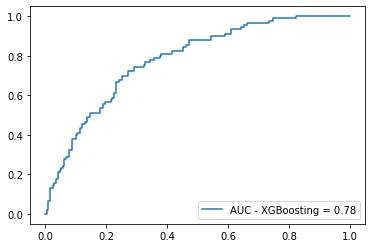

In [15]:
# Plot the precision recall curve
probTest = GridXGB.predict_proba(x_test)
probTest = probTest[:, 1]

# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, 
                                 probTest)

# Save the AUC in a variable to display it. Round it first
auc = np.round(roc_auc_score(y_true = y_test, 
                             y_score = probTest),
               decimals = 3)

# Create and show the plot
plt.plot(fpr,tpr,label="AUC - XGBoosting = " + str(auc))
plt.legend(loc=4)
plt.show()

Now that we have a fully trained XGB models we can study the impact of the variables using Shapley Values.

## Overall impact

The first step is to obtain the global importance. The variable_importance property in the XGB algorithm includes only the data from the gain in Gini. The one derived from Shapley values compares values of cases against each other. Let's study the difference.

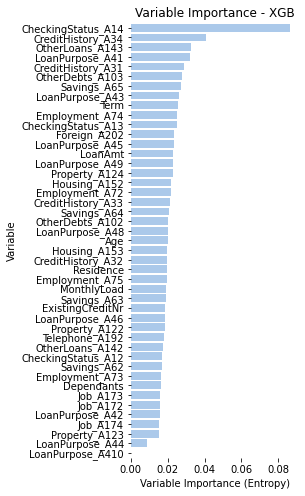

In [ ]:
# Variable importance - from XGB (done this already in XGB lecture)
importances = GridXGB.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1] 

f, ax = plt.subplots(figsize=(3, 8))
plt.title("Variable Importance - XGB")
sns.set_color_codes("pastel")
sns.barplot(y=[x_train.columns[i] for i in indices], 
            x=importances[indices], 
            label="Total", color="b")
ax.set(ylabel="Variable",
       xlabel="Variable Importance (Entropy)")
sns.despine(left=True, bottom=True)

This plot consider each importance independently, however **variable importances are additive**, thus you can add the importances from the discrete variables to get a per-variable instead of a per-dummy variable. The same applies to Shap.

Shap will calculate the average contribution per variable using its game-theoretic approach (see the lectures). This will necessarily be different than the Gini approach from the XGB operator. The Gini approach aims at average contribution per tree (e.g. at a population level), the Shap one at an average contribution per case.

In order to create all the plots in the Shap package, it is first necessary to calculate the Shap contributions. This should be done over a relatively small set as it otherwise can take a long time. We will use the test set for this.

In [16]:
# the variable importance by mean-shap values
explainer = shap.Explainer(GridXGB.best_estimator_)
shap_values = explainer(x_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Now that we have the explainer calculated, we can estimate the impact over all variables. This will average the contributions for each pair of cases.

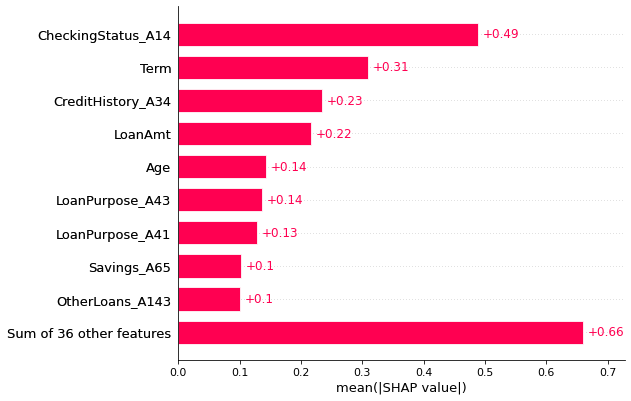

In [25]:
# Report the average importances.
shap.plots.bar(shap_values)

## Per case impact

The second very useful plot is the waterfall plot that shows the impact of each variable in a specific case. This satisfies the explainability requirements in most legistlations. As the model is non-linear, the impacts can be very different for each person.

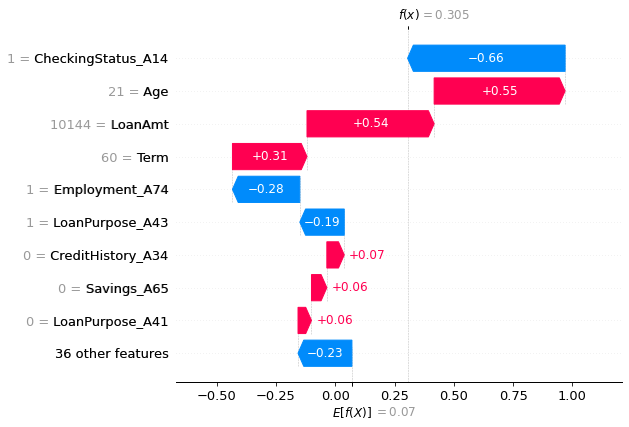

In [26]:
shap.plots.waterfall(shap_values[0])

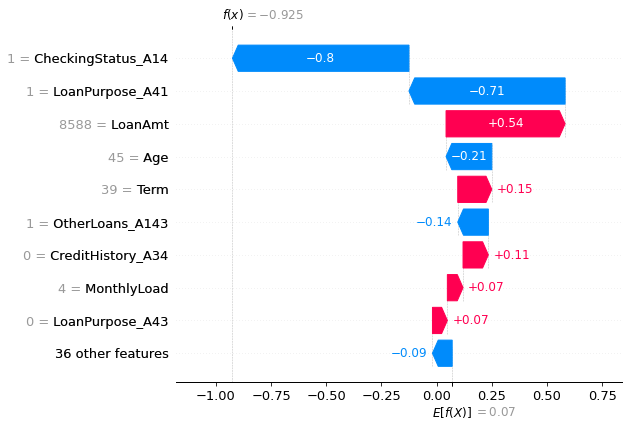

In [29]:
shap.plots.waterfall(shap_values[10])

An alternative are the force plots, which show the same information in a line. This requires having javascript installed though.

In [28]:
shap.initjs()
shap.plots.force(shap_values[0])

## Per variable impact

A third way to visualize the impact of variables is by plotting a scatterplot of the Shapley value (i.e. the normalized impact in the prediction) and the value of the variable. This will allow us to see how the prediction varies across the different values, also evidencing non-linearities. The shap package also codes the scatterplot by colour using the most correlated variable.

For example, the term function presents a clear non-linear pattern, which is consistent with its most correlated variable: LoanPurpose_A41, also presenting the same (binary) behaviour).

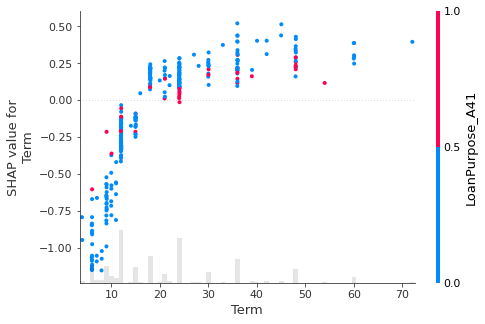

In [ ]:
# Scatter
shap.plots.scatter(shap_values[:,"Term"], color=shap_values)

Age shows an inverse pattern, but it's most correlated variable does not show the same consistency.

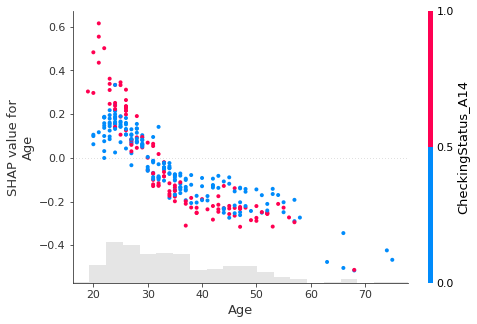

In [ ]:
shap.plots.scatter(shap_values[:,"Age"], color=shap_values)

## Putting it all together

A final, and very useful, plot puts together the per variable impact and the per case impact by plotting the Shapley value on the x-axis, the amount of cases with that Shapley value on the distribution plot, and finally using colour coding to represent the value of the variables. This is called a beeswarm plot.

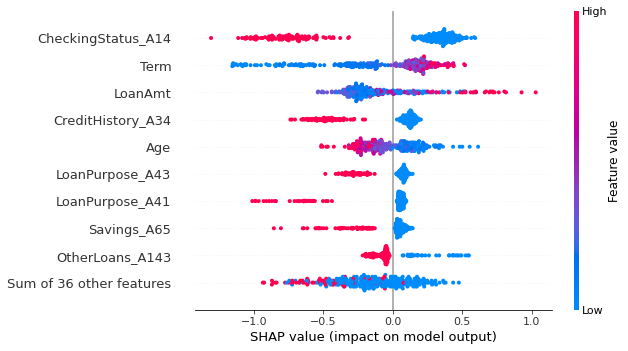

In [ ]:
shap.plots.beeswarm(shap_values)

We can now see how each feature behave and how they contribute to the prediction. For example, the binary variable CheckingStatus_A14 has a non-linear  impact, that's consistent across all cases. For a value of 1, it consistently provides a reduction in risk (negative Shapley value) but this reduction varies between approximately -1.5 (very high impact in prediction) to less than 0.5. (moderate impact). For a value of 0, the prediction impact is moderate and much more concentrated.

Analyze the rest!

## Confounding

Studying confounding is much more difficult. Confounding is the problem of identifying if a variable is caused by an alternative factor. A consequence of confounding is that it can add discrimination by undersirable variables or discriminate against specific groups. There is no standardized test to identify confounding. What is necessary is to measure the relation of variables that we do not want to discriminate by checking them and studying their relation.

A good strategy is to run a pairplot of all predictive variables and use the variable we want to control by as hue. With this:

- For discrete controls, we can see if the distributions between different strata of the variable (as determined by the control variable) present different distributions. If they do, then that variable is also discriminating by the control and needs to be treated to eliminate that impact. For example, segmenting can be used to eliminate the differences in between the distributions, or use one of the continuous variable methods below.

- For continuous controls, correlations can be seen to determine the same effect. In this case, segmenting will most likely not be helpful and removing the offending variable from the model should be considered, or adding an interaction term (Variable * Control) and then using, e.g., the average of the prediction across all values of the control.

Let's study our dataset.

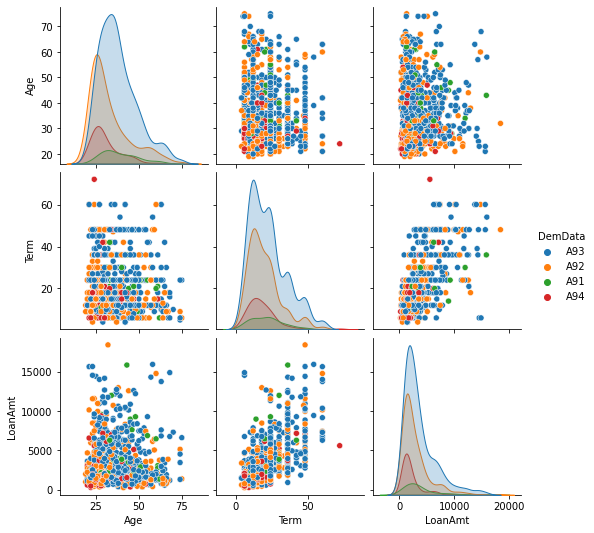

In [ ]:
sns.pairplot(GCData[['Age', 'Term', 'LoanAmt', 'DemData']], hue='DemData')
plt.show()

In this case, Age shows different distributions depending on the values of the demographic segmentation. This means the model, by using Age, is discriminating also by the factors, so if this is not desirable, a control method should be use such segmenting,  interacting and averaging between all cases, or removing age  from the model.

Fair models are a nascent area of research, so these methods and recommendations are bound to evolve in the coming years. Always be mindful of what you are doing and who your models may affect!